In [1]:
from collections import Counter
from warnings import filterwarnings
filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import zscore

from sklearn.datasets import load_breast_cancer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from seaborn import heatmap, countplot

In [2]:
data = load_breast_cancer().data
target = load_breast_cancer().target
target_names = load_breast_cancer().target_names
columns = load_breast_cancer().feature_names

In [3]:
# Remove whitespace in column names
columns = list(map(lambda x: x.strip().replace(' ', '_'), columns))

In [4]:
df = pd.DataFrame(data, columns=columns)
print(df.shape)
df.head()

(569, 30)


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
# Check for missing values
print(df.isnull().any())

mean_radius                False
mean_texture               False
mean_perimeter             False
mean_area                  False
mean_smoothness            False
mean_compactness           False
mean_concavity             False
mean_concave_points        False
mean_symmetry              False
mean_fractal_dimension     False
radius_error               False
texture_error              False
perimeter_error            False
area_error                 False
smoothness_error           False
compactness_error          False
concavity_error            False
concave_points_error       False
symmetry_error             False
fractal_dimension_error    False
worst_radius               False
worst_texture              False
worst_perimeter            False
worst_area                 False
worst_smoothness           False
worst_compactness          False
worst_concavity            False
worst_concave_points       False
worst_symmetry             False
worst_fractal_dimension    False
dtype: boo

In [6]:
# Check for duplicate rows
print(df.duplicated().any()) # No two records are exactly the same

False


In [7]:
# Check for imbalanced classes
class_values, class_counts = np.unique(target, return_counts=True)
print(list(zip(class_values, class_counts)))

[(0, 212), (1, 357)]


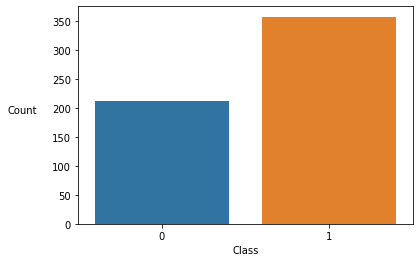

In [8]:
countplot(target)
plt.xlabel('Class')
plt.ylabel('Count', rotation=0, labelpad=30);

Classes are slightly imbalanced but not too badly.

In [9]:
#Check for outliers
outlier_row, outlier_col = np.where(np.abs(zscore(df)>3))#There are some outliers
outlier_values = sorted(zip(outlier_row, outlier_col), key=lambda x: x[0])

print(np.unique(outlier_row))
print(len(np.unique(outlier_row)))


[  0   3   9  12  14  23  25  31  35  42  60  68  71  72  78  82  83 105
 108 112 116 119 122 138 146 151 152 176 180 181 190 192 202 203 212 213
 219 232 236 239 258 259 265 288 290 314 318 323 339 345 351 352 368 370
 376 379 388 389 400 416 417 430 461 473 503 504 505 521 557 559 561 562
 567]
73


There are 73 rows that contain at least one outlier value.

To prevent removing too many rows from the dataset, I will remove rows that have three or more outlier values.

In [10]:
# print(Counter(i[0] for i in outlier_values).most_common())
counter = Counter(outlier_row)
print(counter)

Counter({122: 15, 461: 11, 3: 8, 352: 8, 82: 7, 180: 7, 212: 7, 108: 6, 152: 6, 503: 6, 12: 5, 78: 5, 190: 5, 213: 5, 265: 5, 68: 4, 71: 4, 567: 4, 9: 3, 42: 3, 146: 3, 258: 3, 376: 3, 379: 3, 521: 3, 562: 3, 14: 2, 31: 2, 105: 2, 112: 2, 119: 2, 138: 2, 151: 2, 176: 2, 181: 2, 219: 2, 236: 2, 239: 2, 259: 2, 288: 2, 290: 2, 314: 2, 339: 2, 368: 2, 417: 2, 504: 2, 505: 2, 0: 1, 23: 1, 25: 1, 35: 1, 60: 1, 72: 1, 83: 1, 116: 1, 192: 1, 202: 1, 203: 1, 232: 1, 318: 1, 323: 1, 345: 1, 351: 1, 370: 1, 388: 1, 389: 1, 400: 1, 416: 1, 430: 1, 473: 1, 557: 1, 559: 1, 561: 1})


In [11]:
print([i for i in counter if counter[i] >= 3])

[3, 9, 12, 42, 68, 71, 78, 82, 108, 122, 146, 152, 180, 190, 212, 213, 258, 265, 352, 376, 379, 461, 503, 521, 562, 567]


In [12]:
outlier_row_to_remove = set(i for i in counter if counter[i] >= 3)
print(outlier_row_to_remove)
print(len(outlier_row_to_remove))

{258, 3, 9, 265, 521, 12, 146, 152, 42, 562, 180, 567, 190, 68, 71, 461, 78, 82, 212, 213, 352, 108, 503, 376, 122, 379}
26


In [13]:
df_filtered = df.copy()
df_filtered['DIAG'] = target
df_filtered.drop(index=outlier_row_to_remove, inplace=True)

In [14]:
print(df_filtered.shape)
df_filtered.head()

(543, 31)


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,DIAG
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.2,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,...,23.75,103.4,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0


## Modeling

In [15]:
X = df_filtered.drop('DIAG', axis=1)
y = df_filtered['DIAG']
km = KMeans(n_clusters=2, random_state=50)
km.fit(X)
preds = km.labels_

In [16]:
km.relabels_ = np.choose(preds,[1, 0]).astype(np.int64)
print(round(accuracy_score(y, km.relabels_), 3))

0.867


In [17]:
X = df_filtered.drop(columns[10:], axis=1).drop('DIAG', axis=1)
y = df_filtered['DIAG']
km = KMeans(n_clusters=2, random_state=50)
km.fit(X)
preds = km.labels_

In [18]:
km.relabels_ = np.choose(preds,[1, 0]).astype(np.int64)
print(round(accuracy_score(y, km.relabels_), 3))

0.86


In [19]:
gnb = GaussianNB()

In [20]:
X = df
y = pd.DataFrame(target, columns=['DIAG'])
kf =StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
scores = cross_validate(gnb, X, y, cv=kf, scoring=('accuracy', 'recall', 'roc_auc'))
gnb_accuracy = np.mean(scores['test_accuracy'])
gnb_recall = np.mean(scores['test_recall'])
gnb_roc_auc = np.mean(scores['test_roc_auc'])
print(gnb_accuracy)
print(gnb_recall)
print(gnb_roc_auc)

0.9402847248941901
0.9691705790297341
0.9883016444922766


In [21]:
X = df.drop(columns[10:], axis=1)
y = pd.DataFrame(target, columns=['DIAG'])
scores = cross_validate(gnb, X, y, cv=5, scoring=('accuracy', 'recall', 'roc_auc'))
gnb_accuracy = np.mean(scores['test_accuracy'])
gnb_recall = np.mean(scores['test_recall'])
gnb_roc_auc = np.mean(scores['test_roc_auc'])
print(gnb_accuracy)
print(gnb_recall)
print(gnb_roc_auc)

0.9140130819545979
0.9439358372456963
0.9752035468625708


In [22]:
X = df_filtered.drop(columns[10:], axis=1).drop('DIAG', axis=1)
y = df_filtered['DIAG']
scores = cross_validate(gnb, X, y, cv=5, scoring=('accuracy', 'recall', 'roc_auc'), return_train_score=True, return_estimator=True)
gnb_accuracy = np.mean(scores['test_accuracy'])
gnb_recall = np.mean(scores['test_recall'])
gnb_roc_auc = np.mean(scores['test_roc_auc'])
print(gnb_accuracy)
print(gnb_recall)
print(gnb_roc_auc)

0.9153414882772681
0.9461167002012074
0.9767647993222492


In [23]:
X = df_filtered.drop('DIAG', axis=1)
y = df_filtered['DIAG']
scores = cross_validate(gnb, X, y, cv=5, scoring=('accuracy', 'recall', 'roc_auc'), return_train_score=True, return_estimator=True,)
gnb_accuracy = np.mean(scores['test_accuracy'])
gnb_recall = np.mean(scores['test_recall'])
gnb_roc_auc = np.mean(scores['test_roc_auc'])


In [24]:
scores

{'fit_time': array([0.00199795, 0.00199795, 0.00299692, 0.00199723, 0.00199795]),
 'score_time': array([0.00599432, 0.00399828, 0.0039959 , 0.00400543, 0.00399613]),
 'estimator': (GaussianNB(priors=None, var_smoothing=1e-09),
  GaussianNB(priors=None, var_smoothing=1e-09),
  GaussianNB(priors=None, var_smoothing=1e-09),
  GaussianNB(priors=None, var_smoothing=1e-09),
  GaussianNB(priors=None, var_smoothing=1e-09)),
 'test_accuracy': array([0.9266055 , 0.91743119, 0.95412844, 0.9537037 , 0.92592593]),
 'train_accuracy': array([0.94009217, 0.94470046, 0.93548387, 0.94252874, 0.94482759]),
 'test_recall': array([0.92957746, 0.98591549, 0.97183099, 0.97142857, 0.94285714]),
 'train_recall': array([0.96808511, 0.96099291, 0.96099291, 0.95759717, 0.96113074]),
 'test_roc_auc': array([0.98146775, 0.98406227, 0.99332839, 0.99172932, 0.99172932]),
 'train_roc_auc': array([0.99015491, 0.98945502, 0.98670213, 0.9881207 , 0.98814395])}

In [25]:
print(gnb_accuracy)
print(gnb_recall)
print(gnb_roc_auc)

0.9355589534488618
0.9603219315895373
0.988463412051255
